# Examen final - 14 de noviembre de 2018

## Nombre: John Alexis Munera Mejia

Realiza un algoritmo que compare la diferenciación directa de una imagen con la indirecta, esto es, que encuentra las diferencias de una imagen para un $\Delta_x$ de 5, 10 y 15 píxeles, y lo compare con el resultado de interpolar la imagen y tomar la derivada del polinomio interpolador. Para este procedimiento ten en cuenta las siguientes condiciones:

### Diferenciación directa:

Implementa una estrategia para encontrar los bordes de la imagen utilizando la derivación numérica vista en clase (debes implementar las diferencias regresivas, progresivas o centradas según sea el caso, por tanto no se debe utilizar la función que trae definido python para derivar). Recuerda que en los extremos de la imagen se deben utilizar diferencias regresivas o progresivas.

### Diferenciación indirecta:

1. Se debe aplicar una técnica de interpolación (Lagrange o Newton) que tu implementes (no usar funciones definidas en python).
3. El orden del polinomio debe corresponder con los valores del $\Delta_x$
4. Después de tener el polinomio interpolado se debe hacer la diferenciación del mismo en cada uno de los píxeles que corresponden al rango del $\Delta_x$.
5. Detectar los bordes usando esta estrategia de derivación.

No olvides comentar el código y concluir sobre ambos métodos. Puedes hacer el procedimiento solo para uno de los canales de la imagen (**no** es necesario hacerlo para los tres canales)

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from sympy import *

####  Metodo de lagrange para hallar el polinomio interpolador que se derivara luego

In [104]:
def lagrange(x_arr, y_arr):
    x = Symbol('x')
    factores = []
    if not len(x_arr) == len(y_arr) :
        print('Error, el conjunto de X y Y debe tener la misma cantidad')
        return
    else:
        polinomio = '' # creo polinomio vacio 
        max_k = len(x_arr)
        max_i = len(y_arr)
        for k in range(0, max_k):
            factores_a_multiplicar = [] 
            for i in range(0, max_i):
                if i == k:
                    continue
                factores_a_multiplicar.append('(x-%s)/(%s-%s)' % (x_arr[i], x_arr[k], x_arr[i])) # Agrego los factores que multiplican
            temp_lx = '*'.join(factores_a_multiplicar) 
            temp_lx = '((%s) * %s)' % (temp_lx, y_arr[k])
            factores.append(temp_lx) 
            factores_a_multiplicar = []
        polinomio = '+'.join(factores) # sumo todos los factores
        return simplify(polinomio) #convierto el string creado en polino

#### Metodos para la derivacion directa  de la imagen
Se definen los 3 tipos de derivada y el metodo para recorrer todo el canal mientras se deriva

In [105]:
# implementacion derivada central
def derivar_centrada_directo(indice, delta, vector):
    # accedo en una fila de la imagen al punto necesesario dado delta/2
    return int(round((vector[int(indice + (delta/2))] - vector[int(indice - (delta/2))])/delta))

# implementacion derivada progresiva
def derivar_progresiva_directo(indice, delta, vector):
    # accedo en una fila de la imagen al punto + delta
    return int(round((vector[indice + delta] - vector[indice])/delta))

def derivar_regresiva_directo(indice, delta, vector):
    # accedo en una fila de la imagen al punto - delta
    return int(round((vector[indice] - vector[indice - delta])/delta))

def derivar_canal_directo(canal, limpio, delta):
    for row in range(np.shape(canal)[0]): # recorro la imagen por fila
        for column in range(np.shape(canal)[1]): # recorro por columna
            if column == 0 or (column < delta/2): # verifico si la columna es 0 o menor a delta/2 para evitar fallo de indices
                limpio[row][column] = derivar_progresiva_directo(column, delta, canal[row])
            # verifico si la columna es la ultima o es mayor a la mitad del delta para evitar fallo de indice
            elif column == (len(canal[row]) - 1) or ((column + delta/2) > len(canal[row])-1) :
                limpio[row][column] = derivar_regresiva_directo(column, delta, canal[row])
            # en cualquier otro caso uso centrada
            else:
                limpio[row][column] = derivar_centrada_directo(column, delta, canal[row])
    return limpio

#### Metodos para la derivacion indirecta

Se define el metodo para evaluar el polinio encontrado, la funcion para derivar progresivamente y el metodo para derivar todo un canal progresivamente

In [106]:
def evaluar(funcion, valor): # Funcion para evaluar una funcion
    x = Symbol('x')
    return funcion.subs(x, valor)

# implementacion derivada progresiva
def derivada_progresiva_indirecta(indice, delta, funcion):
    # accedo en una fila de la imagen al punto + delta
    intensidad = int(round((evaluar(funcion, indice + delta) - evaluar(funcion, indice))/delta))
    intensidad = 255 if intensidad != 0 else 0
    return intensidad

def derivar_canal_indirecto(canal, limpia, delta):
    for row in range(0, np.shape(canal)[0]): # recorremos por filas
        for column in range(delta, np.shape(canal)[1], delta):
            list_y = canal[row][column - delta:column] # uso conjuntos de a 7 valores
            list_x = [i for i in range(delta)] # genero el conjunto de 0 a 7 para evaluar
            # valido si en el conjunto elegido existe almenos un cambio de negativo a positivo, asi ahorro tiempo de ejecucion
            if len(np.where(list_y > 0)[0]) > 0:
                pol = lagrange(list_x, list_y) # creo el polinomio
                for indice in range(delta):
                    try:
                        limpia[row][column - delta + indice] = derivada_progresiva_indirecta(indice, delta, pol)
                    except IndexError: # Por si acaso un rango se sale del tamaño de la matriz al estar saltando de delta en delt
                        pass

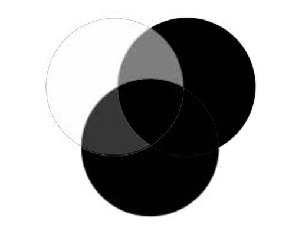

In [107]:
imagen = cv.imread('colores.jpg') # Leo la imagen
canal = imagen[:,:,0]
plt.axis('off')
plt.imshow(canal, cmap='gray')#cv.cvtColor(imagen[0], cv.COLOR_BGR2RGB))
plt.show()

### Metodo directo con los 3 deltas

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.


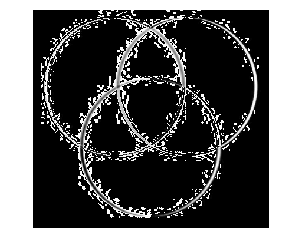

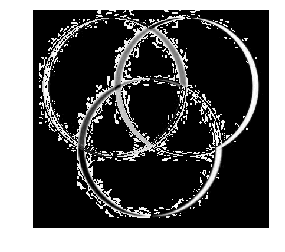

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':


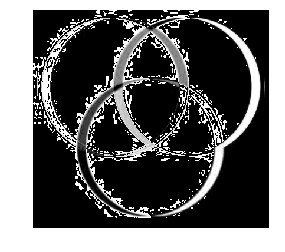

In [108]:
for delta in [5, 10, 15]:
    limpia = np.zeros(np.shape(canal))
    derivar_canal_directo(canal, limpia, delta) # aplico derivacion con cada uno de los deltas
    plt.axis('off')
    plt.imshow(limpia, cmap='gray')
    plt.show()

In [ ]:
limpia_indirecta_5 = np.zeros(np.shape(canal))
derivar_canal_indirecto(canal, limpia_indirecta_5, 5)

In [ ]:
limpia_indirecta_10 = np.zeros(np.shape(canal))
derivar_canal_indirecto(canal, limpia_indirecta_10, 10)

In [ ]:
limpia_indirecta_15 = np.zeros(np.shape(canal))
derivar_canal_indirecto(canal, limpia_indirecta_15, 15)

#### Una pruebita del resultado ya que se demora mucho

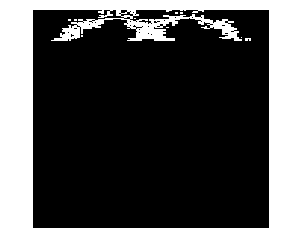

In [110]:
plt.axis('off')
plt.imshow(limpia_indirecta_5, cmap='gray')
plt.show()

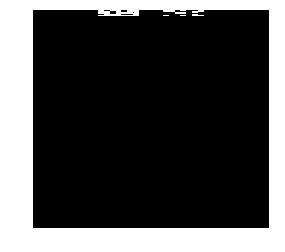

In [112]:
plt.axis('off')
plt.imshow(limpia_indirecta_10, cmap='gray')
plt.show()

In [ ]:
plt.axis('off')
plt.imshow(limpia_indirecta_15, cmap='gray')
plt.show()

#### Conclusion

Con la derivacion directa se encuentran resultados mas rapidos y mas cercanos a los verdaderos bordes que con el indirecto, esto se debe a que los bordes usando el metodo indirecto dependen de un polinomio interpolador que no es tan exacto como la evaluacion directa. Ademas, se toma mas tiempo en generar el polinomio interpolador que se va a derivar.